In [756]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [757]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline

In [758]:
class prediction_model:

	def __init__(self, end_classifier, open_classifier, direction_classifer, filepath):

		self.end_prediction = end_classifier
		self.open_prediction = open_classifier
		self.direction_prediction = direction_classifer
		self.path = filepath

		data = self.translate_data(filepath)


		direction_data = data.copy()
		direction_data['c2cChange'] = direction_data['Close/Last'].shift(-1) - direction_data['Close/Last']
		# direction_data['o2cChange'] = direction_data['Close/Last'] - direction_data['Open']
		# direction_data['o2oChange'] = direction_data['Open'].shift(-1) - direction_data['Open']
		direction_data['c2cDirection'] = direction_data['c2cChange'].apply(lambda x: 1 if x > 0 else -1)
		# direction_data['o2cDirection'] = direction_data['o2cChange'].apply(lambda x: 1 if x > 0 else -1)
		# direction_data['o2oDirection'] = direction_data['o2oChange'].apply(lambda x: 1 if x > 0 else -1)

		
		self.end_prediction_data, self.end_names = self.build_training(data, 'Close/Last')
		self.open_prediction_data, self.open_names = self.build_training(data, 'Open')

		self.direction_prediction_data, self.direction_names = self.build_training(direction_data, 'c2cDirection', True)
		self.direction_prediction_data, self.change_names = self.build_training(self.direction_prediction_data, 'c2cChange')

		### reset indexes
		self.end_prediction_data = self.end_prediction_data.reset_index(drop=True)
		self.open_prediction_data = self.open_prediction_data.reset_index(drop=True)
		self.direction_prediction_data = self.direction_prediction_data.reset_index(drop=True)



		# print(self.end_prediction_data)
		# print(self.open_prediction_data)
		print(self.direction_prediction_data)

		end_X = self.end_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Close/Last', 'Date'] , axis=1)
		end_y = self.end_prediction_data['Close/Last']

		open_X = self.open_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Open', 'Date'] , axis=1)
		open_y = self.open_prediction_data['Open'].shift(-1)

		open_y = open_y.dropna()
		open_X = open_X.drop(open_X.index[-1])

		c2c_dir_X = self.direction_prediction_data.drop(columns=['High', 'Low', 'Volume', 'c2cDirection', 'Date','Open']+self.change_names, axis=1)
		c2c_dir_y = self.direction_prediction_data['c2cDirection'].shift(-1)

		c2c_dir_y = c2c_dir_y.dropna()
		c2c_dir_X = c2c_dir_X.drop(c2c_dir_X.index[-1])

		print("end shapes: ", end_X.shape, end_y.shape)
		print("open shapes: ", open_X.shape, open_y.shape)
		print("direction shapes: ", c2c_dir_X.shape, c2c_dir_y.shape)

		self.end_X_train, self.end_X_test, self.end_y_train, self.end_y_test = train_test_split(end_X, end_y, test_size=0.2, shuffle=False, random_state=0)
		self.open_X_train, self.open_X_test, self.open_y_train, self.open_y_test = train_test_split(open_X, open_y, test_size=0.2, shuffle=False, random_state=0)
		self.direction_X_train, self.direction_X_test, self.direction_y_train, self.direction_y_test = train_test_split(c2c_dir_X, c2c_dir_y, test_size=0.2, shuffle=True, random_state=0)

######
####
##		Helper Functions to handle initiation of the model
#
###
##	Heloper function to ensure that the data is from nasdaq.com
#
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
###
##	Helper function to translate the data to the correct format for analysis
#
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
###
##	Helper function to build the training data from the raw data
#
	def build_training(self, origindf, column, dont_drop=False):
		lags = 5
		names = []

		df = origindf.copy()

		for i in range(1, lags+1):
			df[f'{column}_{i}'] = df[column].shift(i)

			names.append(f'{column}_{i}')

		if not dont_drop:
			df.dropna(inplace=True)

		return df, names
###
##	Helper function to create the columns for the lags
#
	def create_lags(self, df, column, buffer, lags=5):
		
		lag = lags
		names = []

		for i in range(1, lag+1):
			df[f'{column}_{i}'] = []
			names.append(f'{column}_{i}')

		return names
###
##	Helper function to build the test data from the raw data
#
	def build_lags(self, df, column, buffer,row=0, lags=5):
		
		lag = lags

		print("building row: ", row, " for column: ", column)

		if row == 0:
			for i in range(1, lag+1):
				df.loc[row, f'{column}_{i}'] = buffer[(lag-i)]

		else:
			if row > lags:
				for i in range(1, lag+1):
					df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]

			else:
				for i in range(1, lag+1):

					if i <= row:
						df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]
					else:
						df.loc[row, f'{column}_{i}'] = df.loc[row-1, f'{column}_{i-1}']
			
		

		return df
	
	def show_confusion_matrix(self, cm, title, fig=None, ax=None):
		## create the heatmap of the confusion matrix
		sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	## configurations for the plot when not part of a subplot
		if(fig == None):

			### Set the title of the plot
			plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')

			### Add Labels for the different cells of the confusion matrix
			plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')


			### Set the ticks for the x and y axis
			plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
			plt.yticks([0.5, 1.5], ['Negative', 'Positive'])


			### Set the labels for the x and y axis
			plt.ylabel('Actual')
			plt.xlabel('Predicted')

			plt.show()
		else:

		## configurations for the plot when part of a subplot
			ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
			ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

			ax.set_xticks([0.5, 1.5])
			ax.set_xticklabels(['Negative', 'Positive'])
			ax.set_yticks([0.5, 1.5])
			ax.set_yticklabels(['Negative', 'Positive'])

			ax.set_ylabel('Actual')
			ax.set_xlabel('Predicted')

#
##		End of Helper Functions
####
######


######
####
##		Class method to train the model
#
	def train_model(self):

		print("Training the model...")

		print("End X Train:")
		print(self.end_X_train)
		print("Open X Train:")
		print(self.open_X_train)
		print("Direction X Train:")
		print(self.direction_X_train)

		# Fit the model
		self.end_prediction.fit(self.end_X_train, self.end_y_train)
		self.open_prediction.fit(self.open_X_train, self.open_y_train)
		self.direction_prediction.fit(self.direction_X_train, self.direction_y_train)

		return True

######
####
##		Class method to predict the test data
#
	def predict(self, days=7):


		### setup
		predictions_output = pd.DataFrame()

		## Lag buffer setup
		lag_buffer = 5
		end_lag_buffer = self.end_X_train['Open'][len(self.end_X_train['Open'])-lag_buffer:]
		open_lag_buffer = self.open_X_train['Close/Last'][len(self.open_X_train['Close/Last'])-lag_buffer:]
		##reset the index of the lag buffers
		end_lag_buffer = end_lag_buffer.reset_index(drop=True)
		open_lag_buffer = open_lag_buffer.reset_index(drop=True)

		## create the columns for the predictions_output
		predictions_output['Date'] = pd.to_datetime([])
		predictions_output['Open'] = []
		open_names = self.create_lags(predictions_output, 'Open', end_lag_buffer, lag_buffer)
		predictions_output['Close/Last'] = []
		close_names = self.create_lags(predictions_output, 'Close/Last', open_lag_buffer, lag_buffer)




		### create the first row of the dataframe
		# get the next date from the last date in the training data
		last_date = self.end_prediction_data['Date'][len(self.end_y_train)]
		next_date = last_date + pd.DateOffset(days=1)

		predictions_output.loc[0, 'Date'] = next_date

		##get the last row of the dataframe from open_X_train
		last_row = self.open_X_train.iloc[-1]
		## turn into a sample instead of a series
		last_rows = last_row.to_frame().T




		open_prediction = self.open_prediction.predict(last_rows)
		predictions_output.loc[0, 'Open'] = open_prediction[-1]


		self.build_lags(predictions_output, 'Open', end_lag_buffer, 0, lag_buffer)
		self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, 0, lag_buffer)

		end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

		predictions_output.loc[0, 'Close/Last'] = end_predictions[-1]


		## loop through the days
  
		for i in range(1, days):
			
			## get the next date
			next_date = next_date + pd.DateOffset(days=1)

			## add the date to the dataframe
			predictions_output.loc[i, 'Date'] = next_date

			## get the last row of the dataframe
			last_row = predictions_output.iloc[-1]
			## get the open prediction
			open_prediction = self.open_prediction.predict(predictions_output[['Close/Last'] + open_names].iloc[-2].to_frame().T)

			## add the open prediction to the dataframe
			predictions_output.loc[i, 'Open'] = open_prediction

			self.build_lags(predictions_output, 'Open', end_lag_buffer, i, lag_buffer)
			self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, i, lag_buffer)

			## get the close prediction
			end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

			## add the close prediction to the dataframe
			predictions_output.loc[i, 'Close/Last'] = end_predictions[-1]


		self.preds = predictions_output

		self.direction_X_test['predicted_c2c'] = self.direction_prediction.predict(self.direction_X_test)


		return predictions_output
	
######
####
##		Class method to display the graphs of the predictions
#
	def graph(self):

		## create plot with 3 subplots
		fig, ax = plt.subplots(4, figsize=(25, 20))

		## plot the closes and open of training
		ax[0].plot(self.end_prediction_data['Date'][:len(self.end_y_train)], self.end_y_train, label='Training Close Price', color='blue')
		ax[0].plot(self.open_prediction_data['Date'][:len(self.open_y_train)], self.open_y_train, label='Training Open Price', color='green')
		

		## add title and legend
		ax[0].set_title('Close and Open Training Prices')
		ax[0].legend()


		## plot the predictions vs results

		print(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)].shape)
		print(self.end_y_test[:len(self.preds)].shape)

		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.end_y_test[:len(self.preds)], label='Actual Test Close Price', color='yellow', linestyle='-.')
		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.preds['Close/Last'], label='Predicted Test Close Price', color='blue', linestyle='-')

		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.open_y_test[:len(self.preds)], label='Actual Test Open Price', color='blue', linestyle='-.')
		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.preds['Open'], label='Predicted Test Open Price', color='yellow', linestyle='-')

		## add title and legend
		ax[1].set_title('Close and Open Predictions vs Results')
		ax[1].legend()


		## plot the direction predictions vs results
		ax[2].plot(self.direction_prediction_data['Date'][len(self.direction_y_train): len(self.direction_y_train) + len(self.direction_y_test)], self.direction_y_test.cumsum(), label='Actual Direction', color='yellow', linestyle='-.')
		ax[2].plot(self.direction_prediction_data['Date'][len(self.direction_y_train): len(self.direction_y_train) + len(self.direction_X_test) ], self.direction_X_test['predicted_c2c'].cumsum(), label='Predicted Direction', color='blue', linestyle='-')

		## add title and legend
		ax[2].set_title('Direction Predictions vs Results')
		ax[2].legend()

		plt.show()

	def evaluate(self):
		
		end_prediction_score = self.end_prediction.score(self.end_X_test, self.end_y_test)
		open_prediction_score = self.open_prediction.score(self.open_X_test, self.open_y_test)
		direction_prediction_score = self.direction_prediction.score(self.direction_X_test.drop(columns='predicted_c2c', axis=1), self.direction_y_test)

		print("End Prediction Score: ", end_prediction_score)
		print("Open Prediction Score: ", open_prediction_score)
		print("Direction Prediction Score: ", direction_prediction_score)

		# c2c_cm = confusion_matrix(self.direction_y_test, self.direction_X_test['predicted_c2c'])
		
		# self.show_confusion_matrix(c2c_cm, 'DIRECTION')

		return end_prediction_score, open_prediction_score, direction_prediction_score

In [759]:
prediction = prediction_model(
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	AdaBoostClassifier(n_estimators=100, learning_rate=3, algorithm='SAMME',
			estimator=RandomForestClassifier(
									n_estimators=50, 
									random_state=42,
									min_samples_split=7,
									min_samples_leaf=3,
									criterion='gini',
									bootstrap=True,
									)),
	"csvs/stocks/tsla/tsla.csv")

Data is in the correct format and likely origins from nasdaq.com
           Date  Close/Last     Volume      Open      High       Low  \
0    2014-04-30     13.8593   66482412   13.5733   13.8773   13.4187   
1    2014-05-01     13.8487   81526999   13.8053   14.2680   13.7127   
2    2014-05-02     14.0607   61231619   13.9067   14.0907   13.7680   
3    2014-05-05     14.4407   77120601   13.9653   14.5127   13.9013   
4    2014-05-06     13.8187   84300903   14.4400   14.5773   13.7900   
...         ...         ...        ...       ...       ...       ...   
2506 2024-04-15    161.4800  100245300  170.2400  170.6900  161.3800   
2507 2024-04-16    157.1100   96999960  156.7420  158.1900  153.7500   
2508 2024-04-17    155.4500   82439720  157.6400  158.3300  153.7800   
2509 2024-04-18    149.9300   96098830  151.2500  152.2000  148.7000   
2510 2024-04-19    147.0500   87074500  148.9700  150.9400  146.2200   

      c2cChange  c2cDirection  c2cDirection_1  c2cDirection_2  c2cDire

In [760]:
prediction.train_model()

Training the model...
End X Train:
          Open  Close/Last_1  Close/Last_2  Close/Last_3  Close/Last_4  \
0      13.5733       13.7947       13.2340       13.3233       13.8573   
1      13.8053       13.8593       13.7947       13.2340       13.3233   
2      13.9067       13.8487       13.8593       13.7947       13.2340   
3      13.9653       14.0607       13.8487       13.8593       13.7947   
4      14.4400       14.4407       14.0607       13.8487       13.8593   
...        ...           ...           ...           ...           ...   
2004  327.0250      328.9833      325.3100      341.8300      352.4200   
2005  333.0966      340.7900      328.9833      325.3100      341.8300   
2006  329.6766      328.3333      340.7900      328.9833      325.3100   
2007  335.0200      334.7633      328.3333      340.7900      328.9833   
2008  343.3333      342.7166      334.7633      328.3333      340.7900   

      Close/Last_5  
0          13.8660  
1          13.8573  
2          13

True

In [761]:

prediction.predict(503)

building row:  0  for column:  Open
building row:  0  for column:  Close/Last
building row:  1  for column:  Open
building row:  1  for column:  Close/Last
building row:  2  for column:  Open
building row:  2  for column:  Close/Last
building row:  3  for column:  Open
building row:  3  for column:  Close/Last
building row:  4  for column:  Open
building row:  4  for column:  Close/Last
building row:  5  for column:  Open
building row:  5  for column:  Close/Last
building row:  6  for column:  Open
building row:  6  for column:  Close/Last
building row:  7  for column:  Open
building row:  7  for column:  Close/Last
building row:  8  for column:  Open
building row:  8  for column:  Close/Last
building row:  9  for column:  Open
building row:  9  for column:  Close/Last
building row:  10  for column:  Open
building row:  10  for column:  Close/Last
building row:  11  for column:  Open
building row:  11  for column:  Close/Last
building row:  12  for column:  Open
building row:  12  for 

,Date,Open,Open_1,Open_2,Open_3,Open_4,Open_5,Close/Last,Close/Last_1,Close/Last_2,Close/Last_3,Close/Last_4,Close/Last_5
0,2022-04-22,343.693543,343.333300,335.020000,329.676600,333.096600,327.025000,342.076320,342.716600,334.763300,328.333300,340.790000,328.983300
1,2022-04-23,342.292105,343.693543,343.333300,335.020000,329.676600,333.096600,342.344049,342.076320,342.716600,334.763300,328.333300,340.790000
2,2022-04-24,342.669922,342.292105,343.693543,343.333300,335.020000,329.676600,342.905281,342.344049,342.076320,342.716600,334.763300,328.333300
3,2022-04-25,343.413175,342.669922,342.292105,343.693543,343.333300,335.020000,343.177545,342.905281,342.344049,342.076320,342.716600,334.763300
4,2022-04-26,343.609319,343.413175,342.669922,342.292105,343.693543,343.333300,343.516217,343.177545,342.905281,342.344049,342.076320,342.716600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2023-09-02,510.703642,510.320614,509.937783,509.555150,509.172713,508.790473,510.537706,510.154851,509.772193,509.389732,509.007468,508.625400
499,2023-09-03,511.086867,510.703642,510.320614,509.937783,509.555150,509.172713,510.920758,510.537706,510.154851,509.772193,509.389732,509.007468
500,2023-09-04,511.470290,511.086867,510.703642,510.320614,509.937783,509.555150,511.304008,510.920758,510.537706,510.154851,509.772193,509.389732
501,2023-09-05,511.853910,511.470290,511.086867,510.703642,510.320614,509.937783,511.687454,511.304008,510.920758,510.537706,510.154851,509.772193


(503,)
(503,)


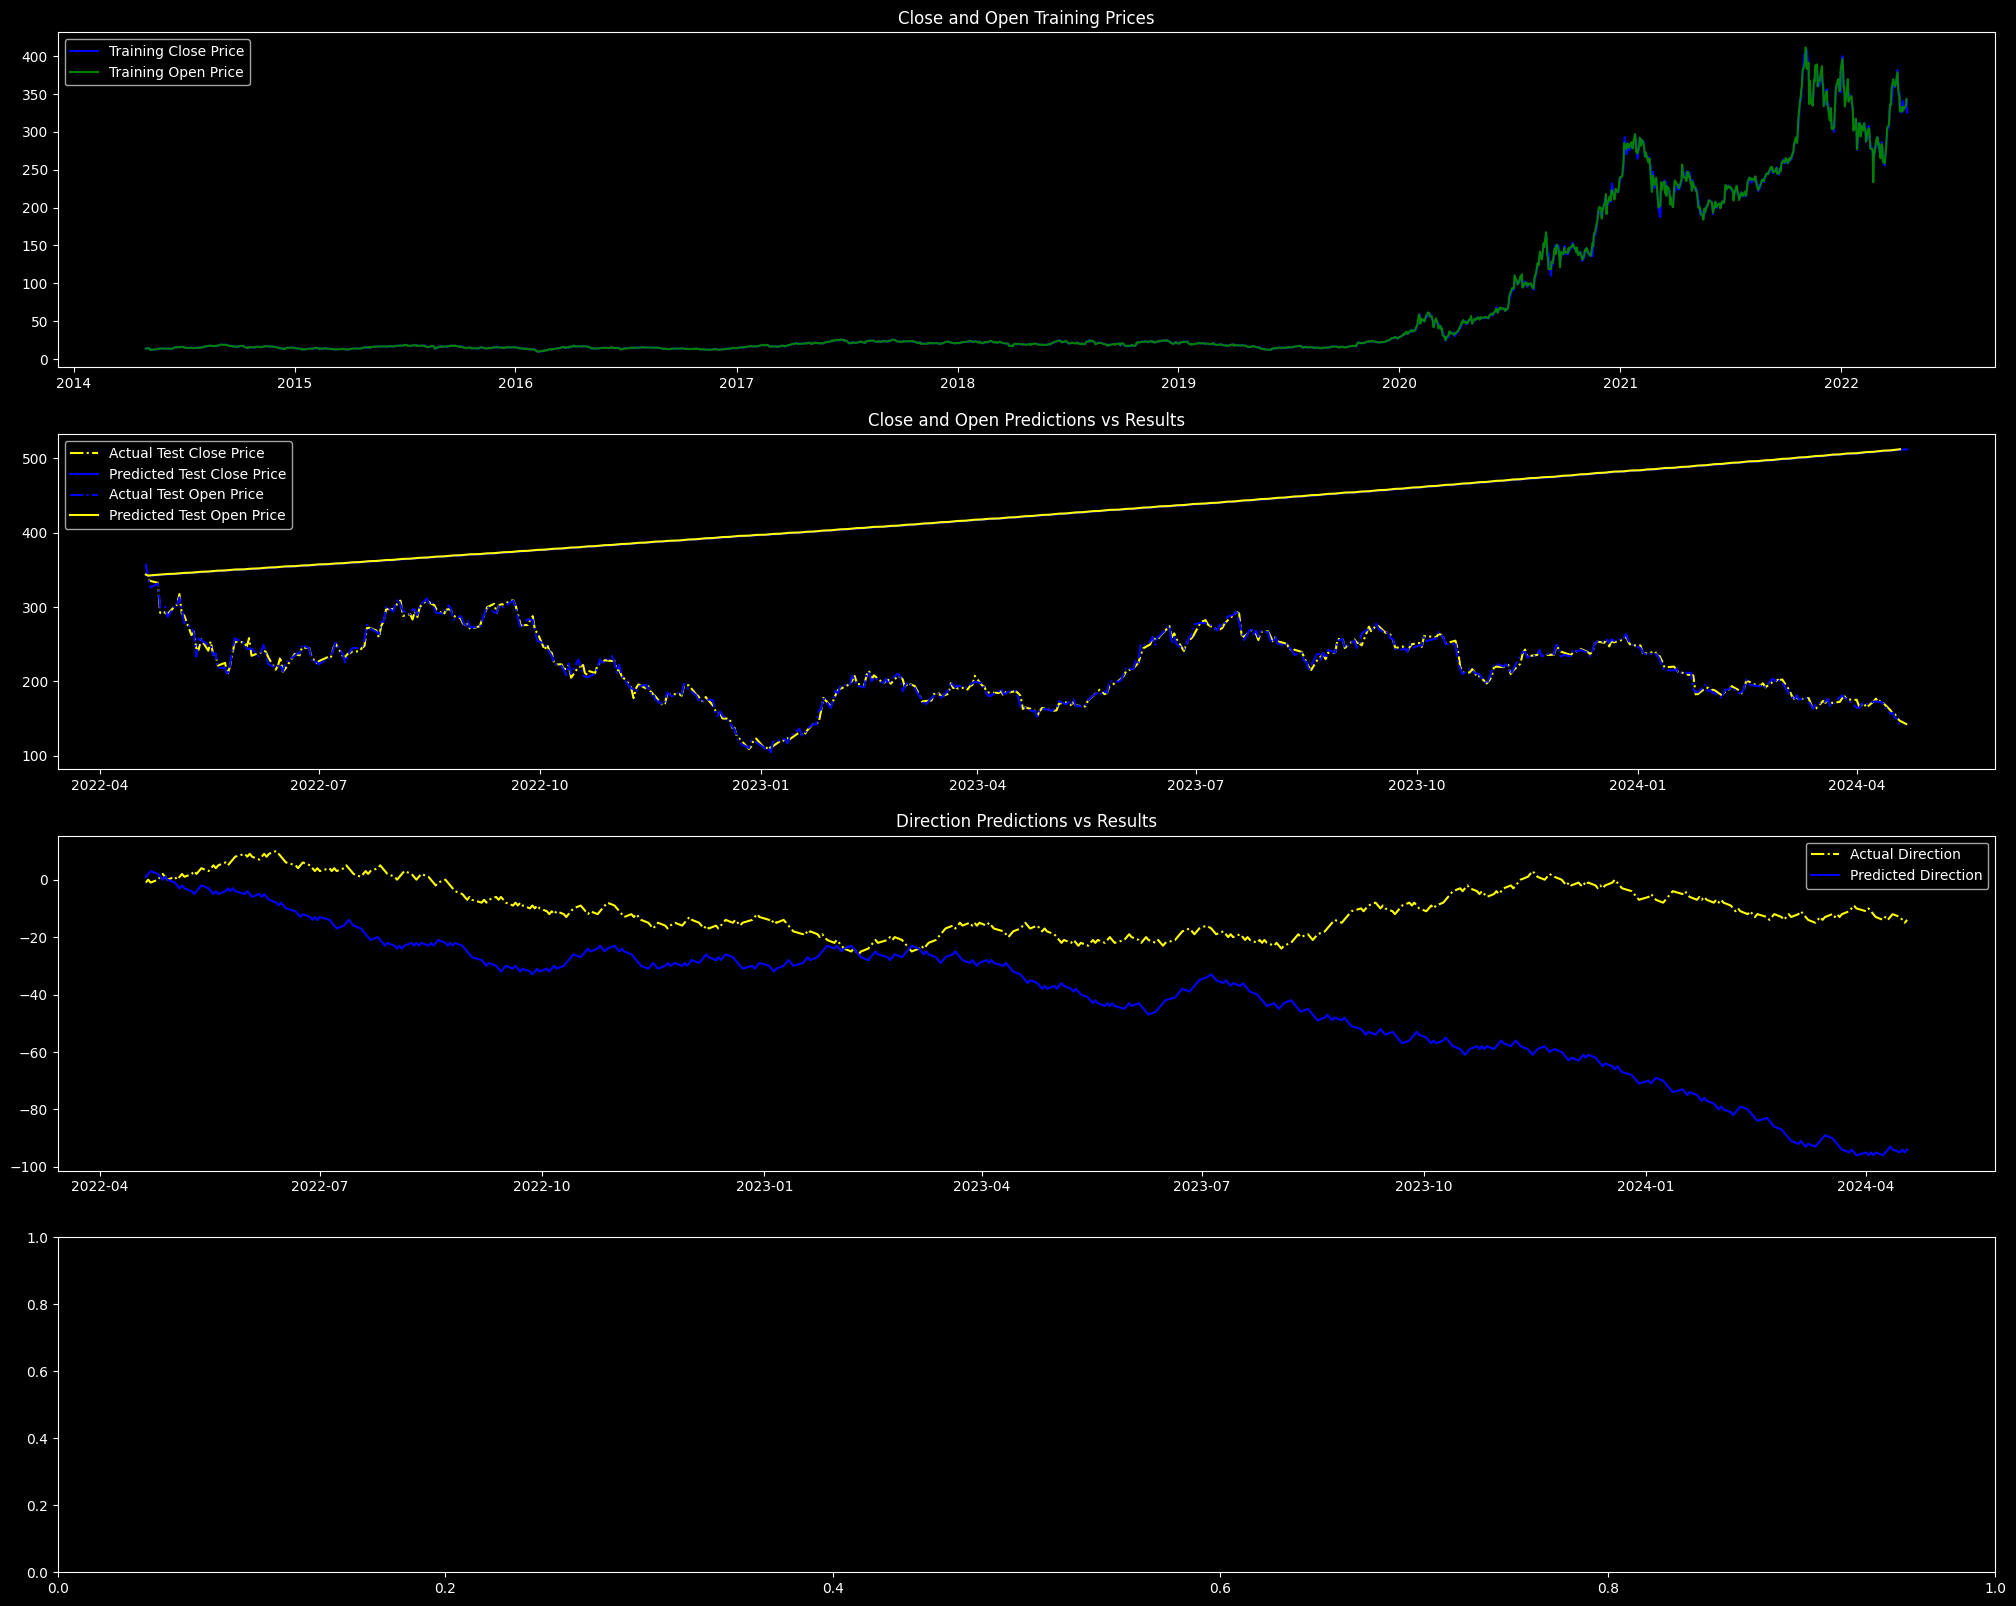

In [762]:
prediction.graph()

In [763]:
prediction.evaluate()

End Prediction Score:  0.9776771253127899
Open Prediction Score:  0.9897966675362698
Direction Prediction Score:  0.46613545816733065


(0.9776771253127899, 0.9897966675362698, 0.46613545816733065)